<a href="https://colab.research.google.com/github/gugi200/final_project/blob/main/project_y4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb -qU
!wandb login 3014974e724f01c4d63f956fa13fd7f0463e16d4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
!pip install torchmetrics
!pip install mlxtend>=0.19.0
!pip list | grep mlx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 5.7 MB/s eta 0:00:00
mlxtend                          0.22.0


In [4]:
#
#   Michael Gugala
#   02/12/2023
#   Image recognition
#   Master 4th year project
#   Univeristy of Bristol
#

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

import torchvision
from torchvision import datasets#
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchmetrics
from torchvision.models import resnet50, ResNet50_Weights
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from PIL import Image

from pathlib import Path

import wandb
import cv2
from timeit import default_timer as timer
from tqdm.auto import tqdm

# check imports
print(torch.__version__)
print(torchvision.__version__)

#agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.1.0+cu118
0.16.0+cu118


'cuda'

In [5]:
# downloiad test data
from torchvision.datasets import FashionMNIST
from torchvision import transforms

train_data = FashionMNIST(
    root='~/.pytorch/F_MNIST_data',
    download=True,
    train=True,
    target_transform=None)

test_data = FashionMNIST(
    root='~/.pytorch/F_MNIST_data',
    download=True,
    train=False,
    target_transform=None)

class_names = [x.replace('/', '_').replace('-', '') for x in train_data.classes]

transform = transforms.ToPILImage()



from pathlib import Path

data_path = Path("data/")
image_path1 = data_path / "FashionMNIST" / "train"

if image_path1.is_dir():
    print('directory already exists')
else:
    print('creating folder')
    for class_name in class_names:
        image_class_path = image_path1 / class_name
        image_class_path.mkdir(parents=True, exist_ok=True)

    for idx, (train_img, target) in enumerate(zip(train_data.data[:1000], train_data.targets[:1000])):
        train_data_PIL = transform(train_img)
        file = "data_" + str(idx) + '.jpg'
        # print(target)
        # print(data_path / "FashionMNIST"/"train" / class_names[target] /file)
        train_data_PIL.save(data_path / "FashionMNIST"/"train" / class_names[target] /file)


data_path = Path("data/")
image_path2 = data_path / "FashionMNIST" / "test"
if image_path2.is_dir():
    print('directory already exists')
else:
    print('creating folder')
    for class_name in class_names:
        image_class_path = image_path2 / class_name
        image_class_path.mkdir(parents=True, exist_ok=True)
        image_class_path.mkdir(parents=True, exist_ok=True)

    for idx, (test_img, target) in enumerate(zip(test_data.data[:250], test_data.targets[:250])):
        test_data_PIL = transform(test_img)
        file = "data_" + str(idx) + '.jpg'
        test_data_PIL.save(data_path / "FashionMNIST"/"test" / class_names[target] /file)





100%|██████████| 26421880/26421880 [00:01<00:00, 15865598.65it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269186.02it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5004728.82it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20123277.72it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw

creating folder
creating folder


# Plan of action
A.
1. Create different CNN models
    * a few of my own making
    * restnet
    * maybe something else
2. Train them on MNIST fashion data scaled to 24x24
3. a Loop to find the best hyperparameters

B. Create SVM models in scikit learn
1. Create a pipeline with different hyper parameters


# Prepare data
* trasnform to tensors
* upscale to 256 (restnet size)
* normalize (apply different normalization)

In [6]:
preprocess = transforms.Compose([

    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.25, 0.25, 0.25], std=[0.1, 0.1, 0.1]),
])

train_data = datasets.ImageFolder(root=Path("data/FashionMNIST/train"),
                                 transform=preprocess, # tranform for the data
                                  target_transform=None) # transform for label


test_data = datasets.ImageFolder(root=Path("data/FashionMNIST/test"),
                                 transform=preprocess, # tranform for the data
                                  target_transform=None) # transform for label
class_names = train_data.classes

torch.Size([32, 3, 224, 224]) torch.Size([32])


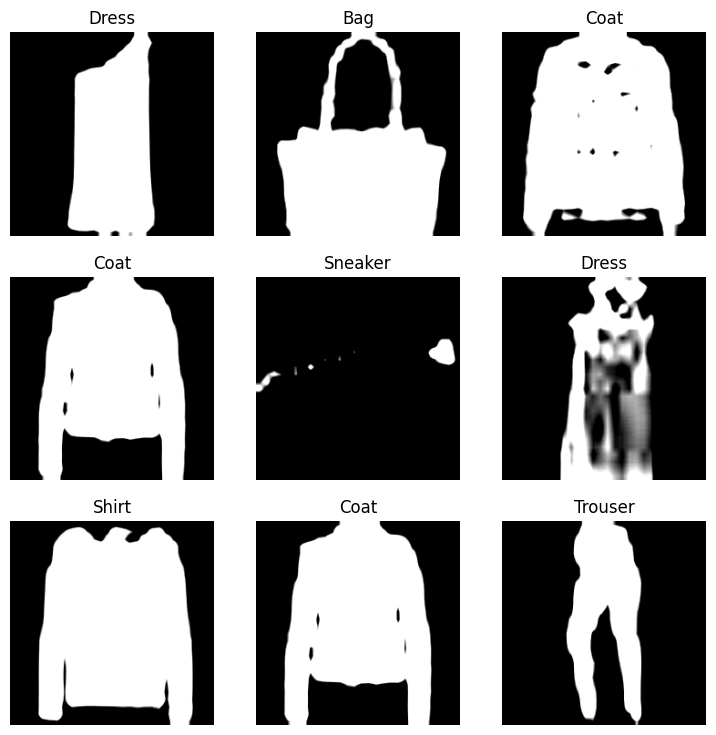

In [7]:
# split data into batches
from torch.utils.data import DataLoader
BATCH_SIZE = 32

# turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) #  shuffling to remove order

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False) # here it doesn't matter, no point to waste resources


# iter tranforms it into iterable, next accesses the next batch
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)

# display random datapoints
fig = plt.figure(figsize=(9, 9))
rows, cols  = 3, 3
for pic in range(1, 1+rows*cols):
    rand_int = np.random.randint(0, BATCH_SIZE)
    img = train_features_batch[rand_int]
    img_RGB = img.permute([1, 2, 0]).numpy()
    fig.add_subplot(rows, cols, pic)
    plt.imshow(img_RGB.squeeze())
    plt.axis(False)
    plt.title(class_names[train_labels_batch[rand_int]])





# Create models



## RestNet

In [8]:
import torch
restnet18_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
restnet18_model

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 33.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Create training loop

create dataset

In [33]:
from pickle import NONE
# create data set from a custom data
def create_dataset(path, batchsize, mean=None, std=None):
    '''
    input:
    path - path to the folder with the data
           eg for train - "data/FashionMNIST/train"
    batchsize - eg 32
    mean (optional)- for normalization eg. [0.25, 0.25, 0.25]
    std (optional)- for nortmalization eg [0.1, 0.1, 0.1]

    returns:
    dataloader with image size of 224
    class_names
    '''
    if mean:
        preprocess = transforms.Compose([

            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    else:
        preprocess = transforms.Compose([

            transforms.Resize(size=(224, 224)),
            transforms.ToTensor()
        ])


    data = datasets.ImageFolder(root=Path(path),
                                    transform=preprocess, # tranform for the data
                                    target_transform=None) # transform for label
    dataloader = DataLoader(dataset=data,
                                batch_size=batchsize,
                                shuffle=True) #  shuffling to remove order
    class_names = data.classes
    return dataloader, class_names

# visdualize 9 random images in a batch
def visualise_data(dataloader, class_names, batchsize):
    '''
    input dataloader
    class names

    displays 9 random images in a batch and their labels
    '''
    train_features_batch, train_labels_batch = next(iter(dataloader))
    print("length of data: ", len(train_features_batch), 'length of labels: ', len(train_labels_batch))
    # display random datapoints
    fig = plt.figure(figsize=(9, 9))
    rows, cols  = 3, 3
    for pic in range(1, 1+rows*cols):
        rand_int = np.random.randint(0, batchsize)
        img = train_features_batch[rand_int]
        img_RGB = img.permute([1, 2, 0]).numpy()
        fig.add_subplot(rows, cols, pic)
        plt.imshow(img_RGB.squeeze())
        plt.axis(False)
        plt.title(class_names[train_labels_batch[rand_int]])


# create optimizer
def create_optiimizer(model, optimizer, lr):
    '''
    inputs:
    model - CNN network
    optimizer - "adam" or "sgd"
    lr - learning rate eg. 0.01

    '''
    if optimizer=='adam':
        optimizer = torch.optim.Adam(model.parameters(),
                                     lr=lr
                                     )
    elif optimizer=='sgd':
        optimizer = torch.optim.SGD(model.parameters(),
                                     lr=lr,
                                    momentum=0.9
                                     )

    return optimizer


def get_lossFn():
    '''
        returns CrossEntropyLoss function
    '''

    return nn.CrossEntropyLoss()

# create train step
def train_step(model, metric, loss_fn, optimizer,
               data_loader, device, debug=False, wnb=True):
    '''
    model - CNN network
    metric - metric to calculate accuracy
    loss_fn - loss function
    optimizer - optimizer to be applied
    data_loader - dataloader
    device - decide for the model to train
    debug (optional)- if True prints average loss and metric of the batch

    returns
    train_loss - average loss of the batch
    train_acc - average metric score of the batch

    The function saves the metric score and loss of each iteration in WandB

    '''
    train_loss, train_acc = 0, 0

    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # put data on the device
        X, y = X.to(device), y.to(device)

        #forward pass, return raw logits
        y_pred = model(X)

        #loss
        loss = loss_fn(y_pred, y)
        #accuracy
        acc = metric(y, torch.argmax(y_pred, dim=1))

        train_loss += loss # accumulate train loss
        train_acc += acc # accumulate train accuracy

        # zero grad
        optimizer.zero_grad()

        # loss bacward
        loss.backward()

        #optimizer step
        optimizer.step()

        # log in wandb
        if wnb:
            wandb.log({"loss": loss,
                       'accuracy': acc})

    # device total loss and accuracy by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    if debug:
        print(f'Train loss: {train_loss:.4f}, Train acc: {train_acc*100:0.4f}%')

    return train_loss, train_acc


# create test step
def test_step(model, metric, loss_fn, data_loader, device, debug=False, wnb=True):
    '''
    model - CNN network
    metric - metric to calculate accuracy
    loss_fn - loss function
    data_loader - dataloader
    device - decide for the model to train
    debug (optional)- if True prints average loss and metric of the batch

    returns
    test_loss - average loss of the batch
    test_acc - average metric score of the batch

    The function saves the metric score and loss of each iteration in WandB

    '''
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            #1 forward pass
            test_pred = model(X_test)

            # calculate loss
            loss = loss_fn(test_pred, y_test)
            test_loss += loss

            #accuracy
            acc = metric(y_test, test_pred.argmax(dim=1))
            test_acc += acc

            if wnb:
                wandb.log({"test loss": loss,
                           'test accuracy': acc})

        # Calculate the test loss average batch
        test_loss /= len(data_loader)

        # acc per bactch
        test_acc /= len(data_loader)

        # Print out what's happening
        if debug:
            print(f'Test loss: {test_loss:.4f}  |  Test acc: {test_acc*100:.4f}%')

        return test_loss, test_acc

# create evaluation loop
def eval_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn,
               device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            #accumulate the loss and acc
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

        # ave loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works if a model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc.item()*100}




def visualize_preds(model, dataloader, class_names, batchsize):
    plt.figure(figsize=(9, 9))
    nrows = 3
    ncols = 3
    model = model.cpu()

    dataL_len = len(dataloader)
    data = iter(dataloader)
    for i in range(3):
        model.eval()
        with torch.inference_mode():

            X, y = next(data)
            X, y = X.cpu(), y.cpu()
            for j in range(3):
                randint = np.random.randint(0, batchsize)
                X_sample, y_sample = X[randint], y[randint]
                pred_logit = model(X_sample.unsqueeze(dim=0))

                pred_prob = pred_logit.argmax(dim=1)


                plt.subplot(nrows, ncols, (3*i)+j+1);
                plt.imshow(X_sample.squeeze().permute([1, 2, 0]), cmap='gray');

                #find pred_label in text form
                pred_label = class_names[pred_prob];

                # find truth label
                truth_label = class_names[y_sample];

                title_text = f'Pred: {pred_label}  \n  Truth: {truth_label}'

                if pred_label==truth_label:
                    plt.title(title_text, fontsize=10, c='g');
                else:
                    plt.title(title_text, fontsize=10, c='r');
                plt.axis(False)
                plt.tight_layout()



def plot_decision_matrix(class_names, y_pred_tensor, targets):
    # setup confusion matrix
    confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
    confmat_tensor = confmat(preds=y_pred_tensor,
                            target=targets)

    # plot consufionmatrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=(10, 7)
    )

def make_predictions(model, data, device):
    model.eval()
    data = data.to(device)
    model = model.to(device)
    with torch.inference_mode():
        y_preds = model(data)
    return y_preds.cpu()


def dataloader_to_numpy(dataloader):
    for i, (data, target) in enumerate(dataloader):
        if i==0:
            data_numpy = data.numpy()
            target_numpy = target.numpy()
        else:
            data_numpy = np.append(data_numpy, data.numpy(), axis=0)
            target_numpy = np.append(target_numpy, target.numpy(), axis=0)
    return data_numpy, target_numpy


## First test loop
test on FashionMNIST with a loop of different hyper parammeters and wandb experiment result collection

length of data:  64 length of labels:  64


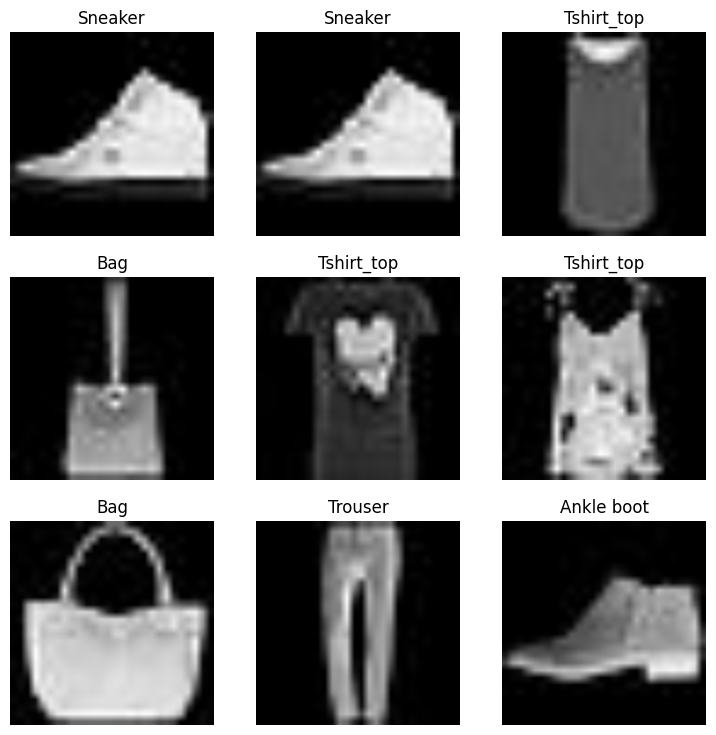

In [10]:
batchsize = 64
train_dataloader, class_names = create_dataset(
                                     path="data/FashionMNIST/train",
                                     batchsize=batchsize
                                     )
test_dataloader, _ = create_dataset(
                             path="data/FashionMNIST/test",
                             batchsize=batchsize
                             )

visualise_data(dataloader=train_dataloader, class_names=class_names, batchsize=batchsize)

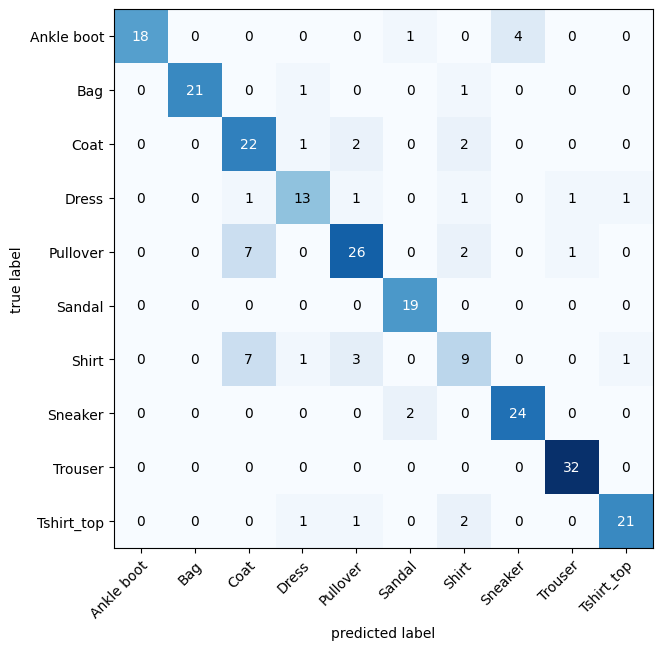

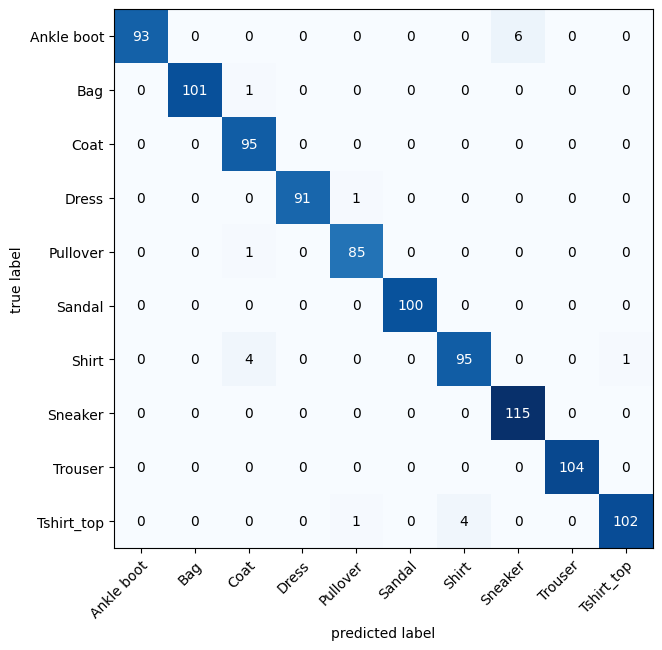

In [36]:
# test with no hyperparameter sweeping
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from torchvision.models import resnet50, ResNet50_Weights

# get data
train_dataloader, class_names = create_dataset(
                                    path="data/FashionMNIST/train",
                                    batchsize=32,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )
test_dataloader, _ = create_dataset(
                            path="data/FashionMNIST/test",
                            batchsize=32,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )

# get model
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(2048, 10)


def train_model_restent50(train_dataloader, test_dataloader, lr, optimizer, batchsize, epochs, class_names, model):
    model = model.to(device)
    loss_fn = get_lossFn()
    optimizer = create_optiimizer(model=model,
                                    optimizer=optimizer,
                                    lr=lr
    )


    metric = torchmetrics.classification.Accuracy(
        task="multiclass",
        num_classes=len(class_names)
    ).to(device)
    train_time_start = timer()
    for epoch in tqdm(range(epochs)):
        ave_batch_loss, ave_batch_metric = train_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            wnb=False,
            debug=True
        )
        ve_batch_loss, ave_batch_metric = test_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            data_loader=test_dataloader,
            device=device,
            wnb=False,
            debug=True
        )

    train_time_end = timer()

    return model

newModel = train_model_restent50(train_dataloader=train_dataloader,
                                 test_dataloader=test_dataloader,
                                 lr=0.001,
                                 optimizer='adam',
                                 batchsize=32,
                                 epochs=10,
                                 class_names=class_names,
                                 model=model).cpu()

visualize_preds(model=newModel,
                dataloader=test_dataloader,
                class_names=class_names,
                batchsize=32)

data_test_numpy, target_test_numpy = dataloader_to_numpy(test_dataloader)

y_test_preds_tensor = make_predictions(model=newModel,
                           data=torch.tensor(data_test_numpy),
                           device=device
                        )

plot_decision_matrix(class_names=class_names,
                     y_pred_tensor=y_test_preds_tensor,
                     targets=torch.tensor(target_test_numpy))


data_train_numpy, target_train_numpy = dataloader_to_numpy(train_dataloader)

y_train_preds_tensor = make_predictions(model=newModel,
                           data=torch.tensor(data_train_numpy),
                           device=device
                        )

plot_decision_matrix(class_names=class_names,
                     y_pred_tensor=y_train_preds_tensor,
                     targets=torch.tensor(target_train_numpy))



In [ ]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)


sweep_config = {
    'method': 'grid'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }
sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [10]
        },
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 10}
    })

# parameters_dict.update({
#     'learning_rate': {
#         # a flat distribution between 0 and 0.1
#         'distribution': 'uniform',
#         'min': 0,
#         'max': 0.1
#       },
#     'batch_size': {
#         # integers between 32 and 256
#         # with evenly-distributed logarithms
#         'distribution': 'q_log_uniform_values',
#         'q': 8,
#         'min': 8,
#         'max': 32,
#       }
#     })

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'values': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.08, 0.01]
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'values': [8, 16, 24, 32, 64]
      }
    })



import pprint
pprint.pprint(sweep_config)


sweep_id = wandb.sweep(sweep_config, project="test-wandb-sweep")



def train_model_restent50(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, class_names = create_dataset(
                                            path="data/FashionMNIST/train",
                                            batchsize=config.batch_size,
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]
                                        )
        test_dataloader, _ = create_dataset(
                                    path="data/FashionMNIST/test",
                                    batchsize=config.batch_size,
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]
                                        )
        model = resnet50(
            weights=ResNet50_Weights.DEFAULT).to(device)

        model.fc = nn.Linear(2048 , config.fc_layer_size).to(device)

        loss_fn = get_lossFn()
        optimizer = create_optiimizer(model=model,
                                      optimizer=config.optimizer,
                                      lr=config.learning_rate
        )


        metric = torchmetrics.classification.Accuracy(
            task="multiclass",
            num_classes=len(class_names)
        ).to(device)
        train_time_start = timer()
        for epoch in range(config.epochs):
            ave_batch_loss, ave_batch_metric = train_step(
                model=model,
                metric=metric,
                loss_fn=loss_fn,
                optimizer=optimizer,
                data_loader=train_dataloader,
                device=device,
                debug=True
            )
            ve_batch_loss, ave_batch_metric = test_step(
                model=model,
                metric=metric,
                loss_fn=loss_fn,
                data_loader=test_dataloader,
                device=device,
                debug=True
            )
            wandb.log({"average train batch loss": ave_batch_loss,
                       "average train batch metric": ave_batch_metric,
                       "average test batch loss": ave_batch_loss,
                       "average test batch metric": ave_batch_metric,
                       "epoch": epoch
                       })
        train_time_end = timer()
        wandb.log({"train time": train_time_end - train_time_start})

    return model


wandb.agent(sweep_id, train_model_restent50)


